In [1]:
%%writefile Ind_OBVEX_VOL.py

import sys
import os 
module_path = os.path.abspath(os.path.join('..')) 
if module_path not in sys.path: 
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd

import QUANTAXIS as QA

import Ind_Model_Base

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from base.Constants import PLOT_TITLE


class OBV(Ind_Model_Base.Ind_Model):
    '''能量潮指标改进版'''
    optimum_param={'valid':False, 'main':'long_short_ratio', 'desition_direct':-1,  'freq':'d','neutralize':{'enable':True,'static_mv':False}}
    
    def __init__(self,data, frequence=QA.FREQUENCE.DAY):
        super().__init__(data, 'OBV_EX', frequence)
    
    def on_set_params_default(self):
        return {'SHORT':5, 'LONG':15}
        
    def on_indicator_structuring(self, data):
        return self.excute_for_multicode(data, self.kernel, **self.pramas)

    
    def on_desition_structuring(self, data, ind_data):
        """
        1.短期量价穿越长期,res为1，买入信号参考。
        2.相反则res为-1，卖出信号参考。
        """
        if self.fast_mode:
            return None
        return pd.DataFrame({'res':ind_data['CROSS_JC'] + ind_data['CROSS_SC']*-1})
        
    def kernel(self,dataframe,SHORT=5,LONG=15):
        '''多空比率净额= [（收盘价－最低价）－（最高价-收盘价）] ÷（ 最高价－最低价）×V'''
        long_short_ratio=((dataframe.close - dataframe.low) - (dataframe.high - dataframe.close)) / (dataframe.high-dataframe.low) * dataframe.volume
        
        if self.fast_mode:
            return pd.DataFrame({'long_short_ratio':long_short_ratio}) 
        
        short =QA.EMA(long_short_ratio,SHORT)
        long = QA.EMA(long_short_ratio,LONG)
        

        CROSS_JC=QA.CROSS(short, long)
        CROSS_SC=QA.CROSS(long, short)

        return pd.DataFrame({'long_short_ratio':long_short_ratio,'CROSS_JC':CROSS_JC, 'CROSS_SC':CROSS_SC})
#         return pd.DataFrame({'main':long_short_ratio})
    
    
    def plot(self,figsize=(1120/72,420/72)):
        fig = plt.figure(figsize=figsize)
        groups = self.ind_df.groupby(level=1)
        for idx,item in enumerate(groups):
            inds_ = item[1].reset_index('code',drop=True)
            ax = fig.add_subplot(len(groups),1,idx+1)
             
            inds_.plot(ax=ax,legend=True)
            ax.set_title(item[0],color='r', loc ='left', pad=-10)
            ax.xaxis.set_major_locator(ticker.MaxNLocator(10))
            plt.xticks(rotation = 0)
            
    
    def plot_mix(self,figsize=(1120/72,420/72)):
        fig = plt.figure(figsize=figsize)
        groups = self.ind_df.groupby(level=1)
        def x1(item):
            inds_ = item.reset_index('code',drop=True)
            plt.plot(inds_['main'])
#             print(item.name)
        groups.apply(x1)
        plt.legend(groups.groups.keys())
        
    def self_test(self):
        data = get_sample_by_zs(name='上证50', end='2020-06-29', gap=250, only_main=True)
        df = resample_stockdata_low(data.data,freq="M")


Writing Ind_OBVEX_VOL.py


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Now in the main code. Process name is: base.JuUnits
base.JuUnits, subpid:16100  pid:52684


  0%|          | 0/4 [00:00<?, ?it/s]

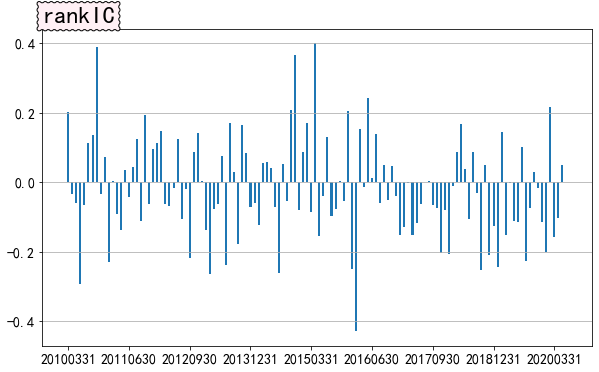

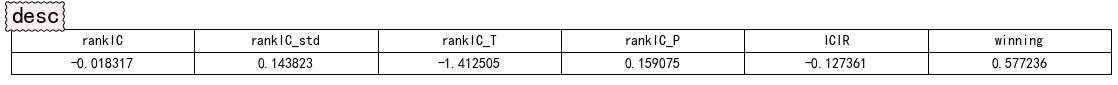

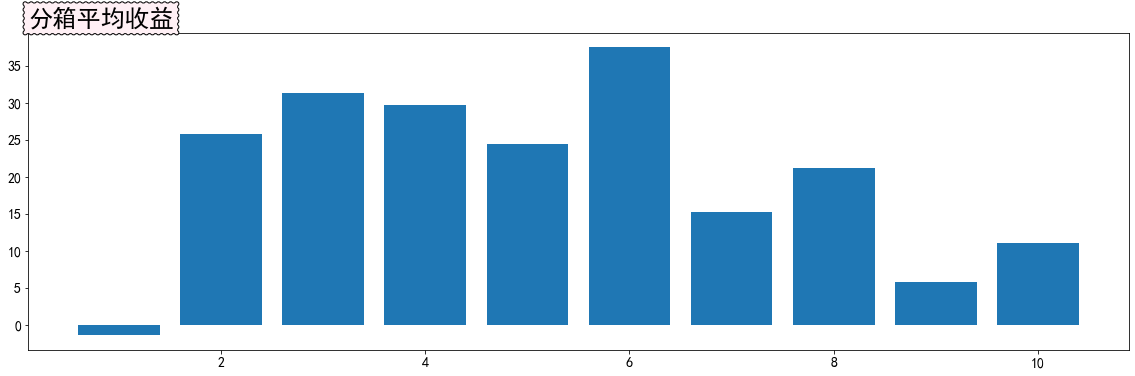

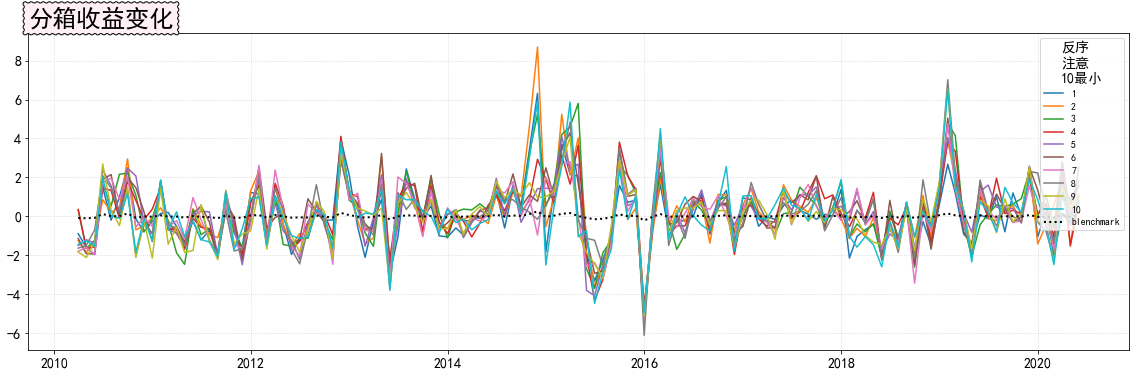

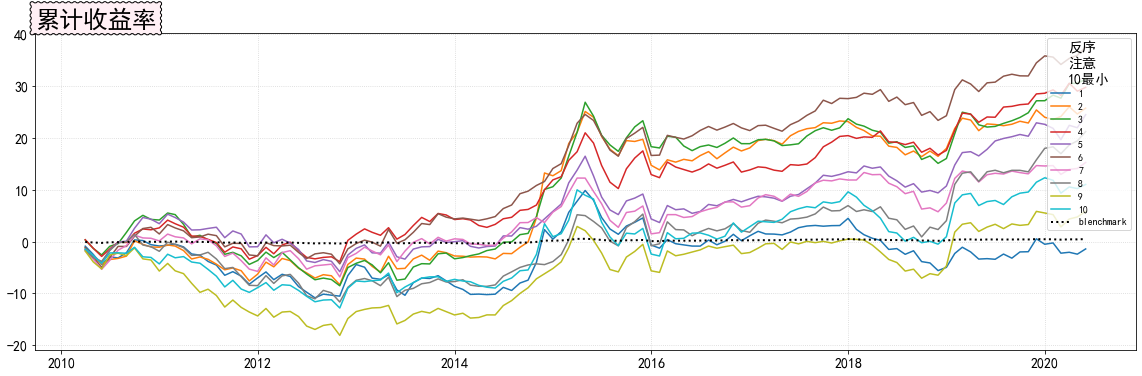

Wall time: 23 s


In [4]:
%%time
import sys
import os 
module_path = os.path.abspath(os.path.join('..')) 
if module_path not in sys.path: 
    sys.path.append(module_path)
from tools.Test_Tools import FactorTest
from ind.Ind_OBV_EX import OBV as OBV_X

%load_ext autoreload
%autoreload 1
%aimport tools.Test_Tools,ind.Ind_OBV_EX


test = FactorTest(OBV_X, sample='沪深300',freq="m",end='2020-06-29',gap=2500,only_main=True,neutralize={'enable':False,'static_mv':False})
test.process_multi()
test.plot()



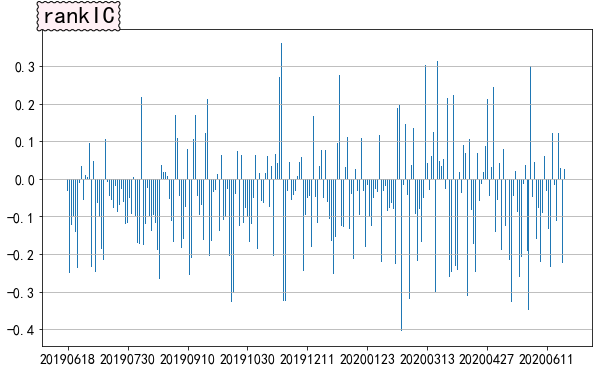

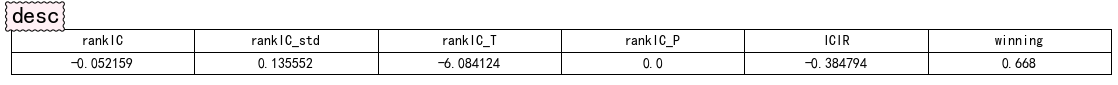

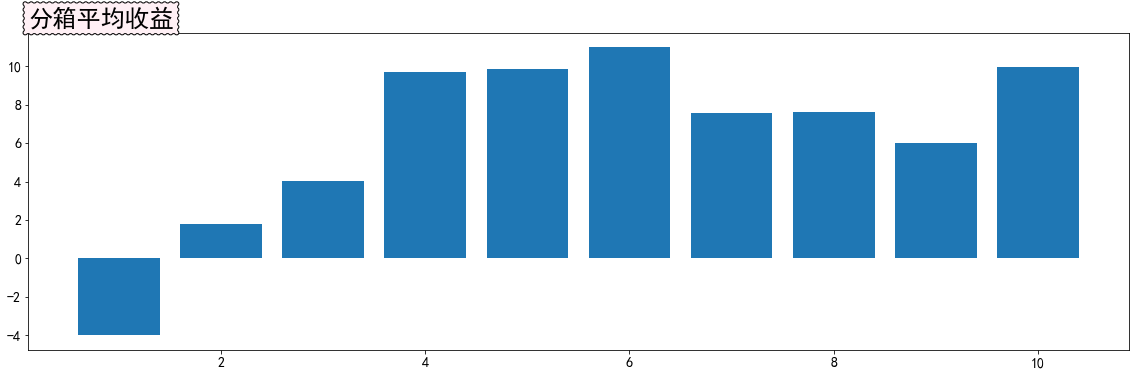

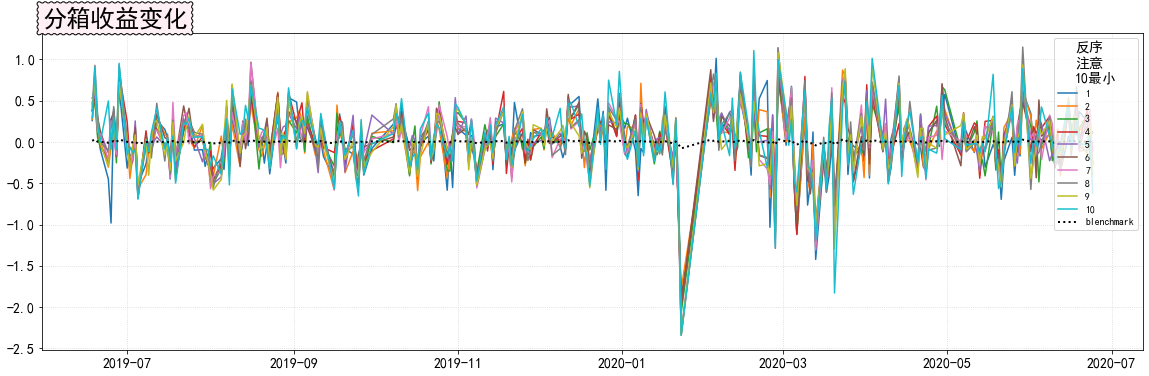

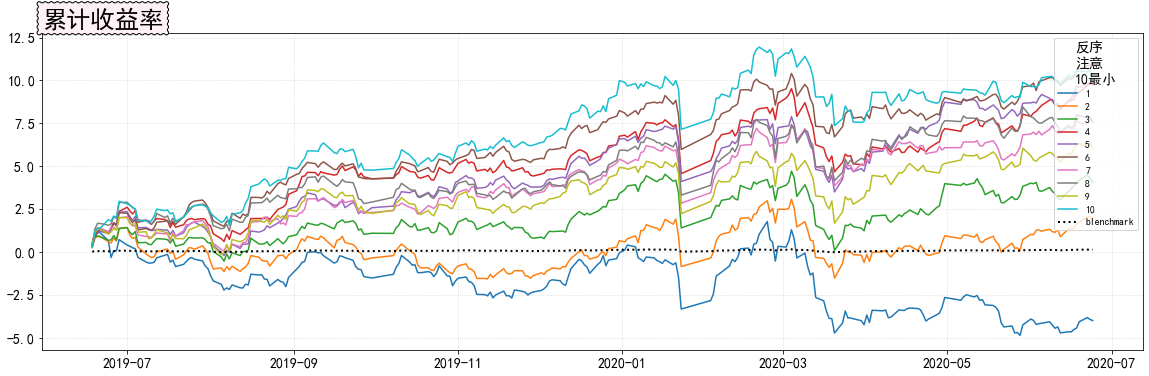

Wall time: 17 s


In [7]:
%%time

test = FactorTest(OBV_X, sample='沪深300',freq="d",end='2020-06-29',gap=250,only_main=True,neutralize={'enable':True,'static_mv':False})
test.process()
test.plot()


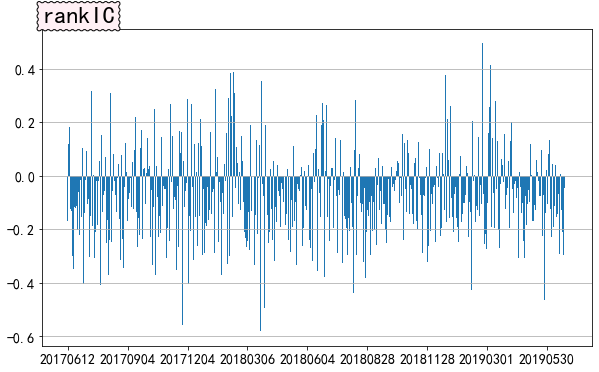

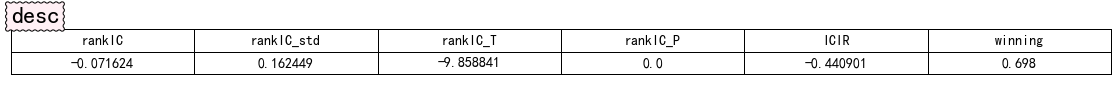

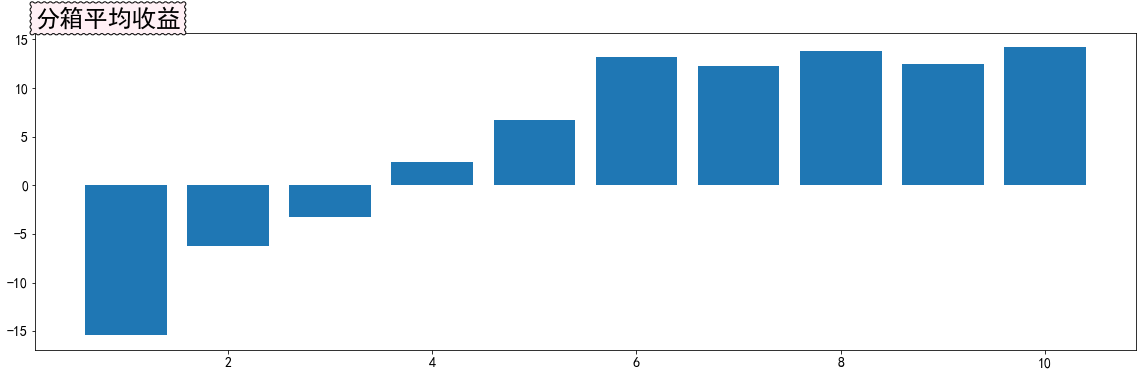

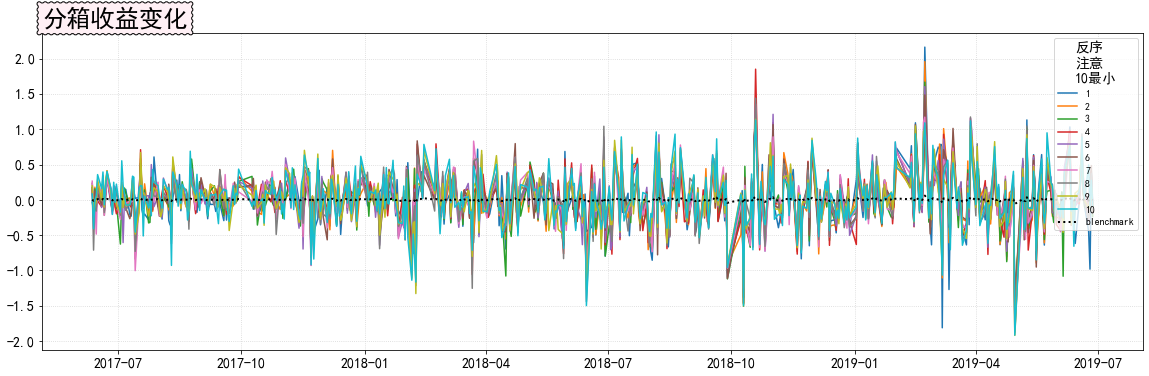

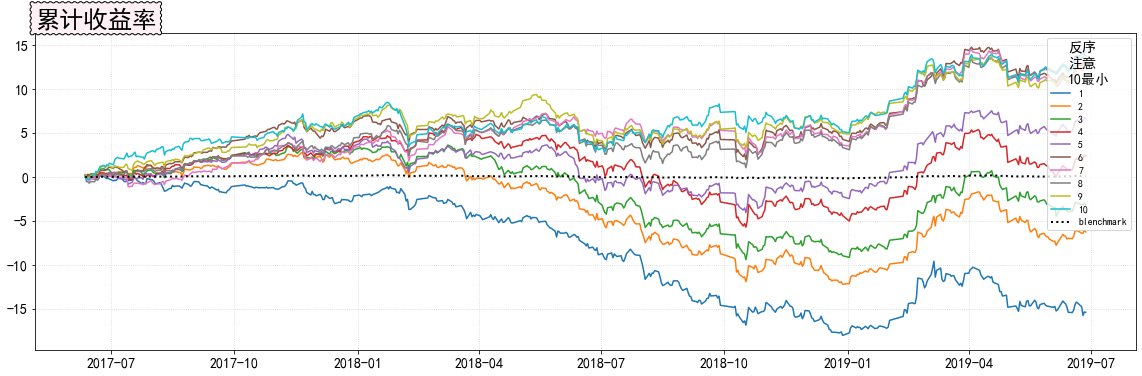

Wall time: 27.1 s


In [8]:
%%time

test = FactorTest(OBV_X, sample='沪深300',freq="d",end='2019-06-29',gap=500,only_main=True,neutralize={'enable':True,'static_mv':False})
test.process()
test.plot()


====================================neutralize start
====================================neutralize true
True False True


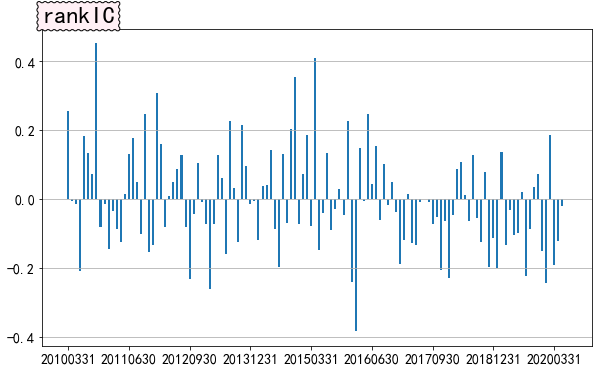

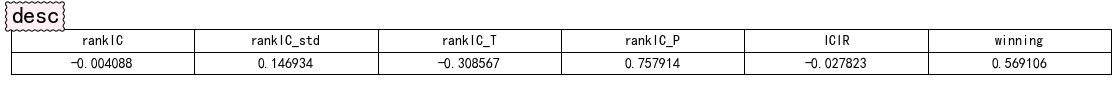

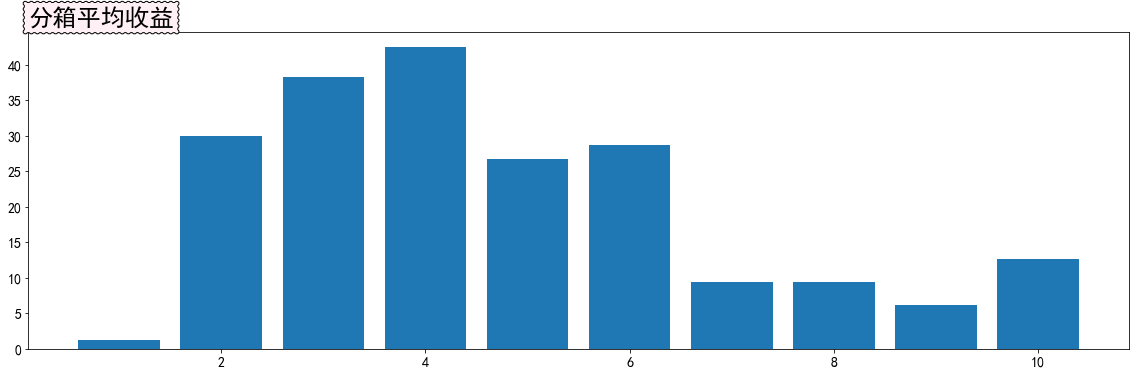

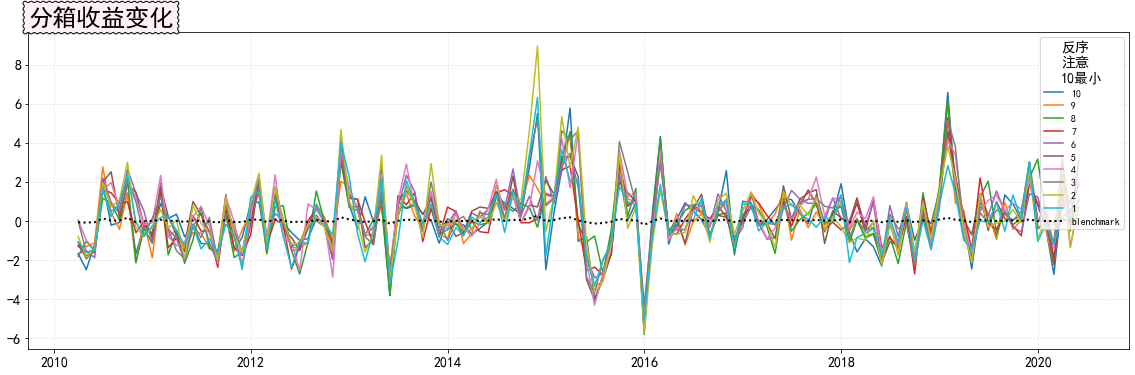

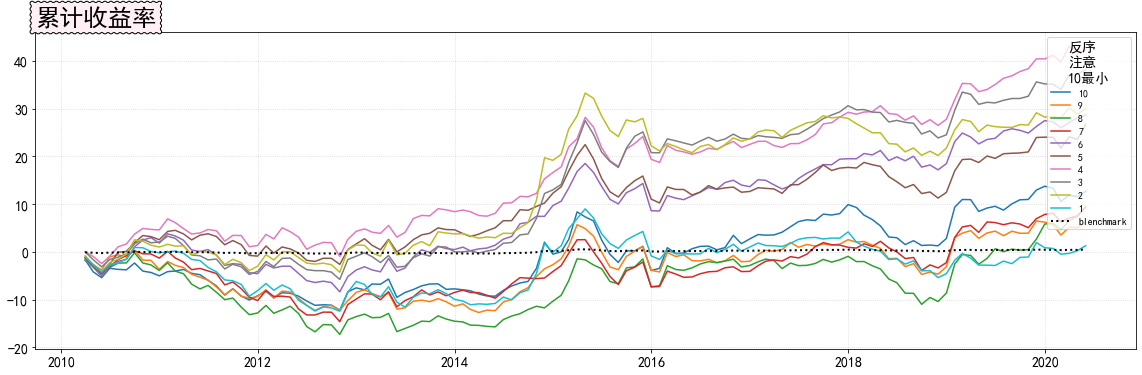

Wall time: 48.3 s


In [80]:
%%time

test = FactorTest(OBV, sample='沪深300',freq="m",end='2020-06-29',gap=2500,only_main=True,neutralize={'enable':True,'static_mv':False})
test.process()
test.plot()

In [19]:
%%time

import Analysis_Funs as af
import tools.Sample_Tools as smpl
import tools.Pretreat_Tools as pretreat
# %load_ext autoreload
# %autoreload 1
# %aimport Analysis_Funs,Sample_Tools,Pretreat_Tools,base.Constants

from QUANTAXIS.QAData.data_marketvalue import QA_data_marketvalue

ttt2 = smpl.get_sample_by_zs(name='上证50', end='2010-04-15', gap=565, only_main=True)
ttt3 = smpl.resample_stockdata_low(ttt2.data,freq="w")


# %time ttt3 = smpl.add_report_inds(ttt3)
%time ttt3 = QA_data_marketvalue(ttt3)
ttt3.rename(columns=lambda x:x.replace('mv','totalCapital'), inplace=True)
%time ttt3 = smpl.add_industry(ttt3)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(ttt3)
ttt4 = ttt3.dropna(axis=0)
ttt4 = ttt4.drop(ttt4[ttt4['totalCapital']==0].index)
close = ttt4.close
ttt4 = ttt4[['totalCapital','industry']]

# print(ttt4[pd.isna(ttt4)])

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     print(ttt4[ttt4['totalCapital']==0])
%time pp = pretreat.neutralize(close, ttt4, categorical=['industry'], logarithmetics=['totalCapital'])
print(pp)
# 


# print(pd.get_dummies(ttt4,['industry']))

Wall time: 245 ms
Wall time: 16 ms
                     open    high     low   close      volume        amount  \
date       code                                                               
2007-12-23 600000   49.10   50.46   48.77   49.13    154450.0  7.655345e+08   
           600009   36.61   37.27   36.48   37.23     36532.0  1.350066e+08   
           600016   14.63   14.85   14.55   14.68    774481.0  1.137143e+09   
           600028   23.05   23.38   22.86   23.11    943428.0  2.181290e+09   
           600030   83.24   84.84   83.00   84.18    168953.0  1.417444e+09   
           600031   51.11   52.59   51.11   52.37     40477.0  2.109756e+08   
           600036   37.51   38.35   37.39   37.91    309061.0  1.170283e+09   
           600048   60.08   62.20   60.00   60.52     34765.0  2.117124e+08   
           600050   10.49   10.81   10.43   10.60   1581277.0  1.688316e+09   
           600104   25.48   26.25   25.38   26.07    110694.0  2.878362e+08   
           600196

In [742]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(pd.concat([pp,ttt4,close],axis=1))

                        close  totalCapital   close
date       code                                    
2009-03-22 600000   -5.471715  5.661347e+09   19.31
           600009  -15.541563  1.926958e+09   13.78
           600016  -14.880791  1.882300e+10    4.84
           600028   -4.516670  8.670244e+10    8.77
           600030   -0.976090  6.630468e+09   23.14
           600031   -7.030526  1.488000e+09   23.38
           600036   -5.930188  1.470718e+10   14.83
           600048   -6.715934  2.452343e+09   21.59
           600050  -13.850515  2.119660e+10    5.37
           600104  -14.626863  6.551029e+09    9.54
           600196  -18.146114  1.237775e+09   13.04
           600276    4.628622  5.172860e+08   39.49
           600309  -16.051294  1.663334e+09   13.89
           600438  -25.052954  6.875200e+08    8.61
           600519   85.551651  9.438000e+08  117.88
           600547   37.991827  3.557681e+08   74.43
           600570  -22.258379  2.970240e+08   14.94
           6

In [150]:
from QUANTAXIS.QAData.financial_mean import financial_dict
financial_dict

{'001基本每股收益': 'EPS',
 '002扣除非经常性损益每股收益': 'deductEPS',
 '003每股未分配利润': 'undistributedProfitPerShare',
 '004每股净资产': 'netAssetsPerShare',
 '005每股资本公积金': 'capitalReservePerShare',
 '006净资产收益率': 'ROE',
 '007每股经营现金流量': 'operatingCashFlowPerShare',
 '008货币资金': 'moneyFunds',
 '009交易性金融资产': 'tradingFinancialAssets',
 '010应收票据': 'billsReceivables',
 '011应收账款': 'accountsReceivables',
 '012预付款项': 'prepayments',
 '013其他应收款': 'otherReceivables',
 '014应收关联公司款': 'interCompanyReceivables',
 '015应收利息': 'interestReceivables',
 '016应收股利': 'dividendsReceivables',
 '017存货': 'inventory',
 '018其中：消耗性生物资产': 'expendableBiologicalAssets',
 '019一年内到期的非流动资产': 'noncurrentAssetsDueWithinOneYear',
 '020其他流动资产': 'otherLiquidAssets',
 '021流动资产合计': 'totalLiquidAssets',
 '022可供出售金融资产': 'availableForSaleSecurities',
 '023持有至到期投资': 'heldToMaturityInvestments',
 '024长期应收款': 'longTermReceivables',
 '025长期股权投资': 'longTermEquityInvestment',
 '026投资性房地产': 'investmentRealEstate',
 '027固定资产': 'fixedAssets',
 '028在建工程': 'constructi